In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

base_dir       = "dataset/train_test_extracted_base"
oversample_dir = "dataset/train_test_extracted_oversample"
overunder_dir  = "dataset/train_test_extracted_overunder"

resampling_map = {
    "none": base_dir,
    "oversample": oversample_dir,
    "overunder": overunder_dir
}

# For bias results (SPD, DI, etc.)
bias_file_map = {
    "none": "bias_results_lumped_OF.csv",
    "all_demographics": "bias_results_lumped_OF_all_demographics.csv",
    "cherry_picked": "bias_results_lumped_OF_cherry_picked.csv"
}

# For model performance (accuracy, recall, auc, etc.)
perf_file_map = {
    "none": "model_results.csv",
    "all_demographics": "model_results_all_demographics.csv",
    "cherry_picked": "model_results_cherry_picked.csv"
}

# 1) Collect bias data
bias_list = []
for resamp, dir_path in resampling_map.items():
    for feat_sel, f_name in bias_file_map.items():
        path = os.path.join(dir_path, f_name)
        if os.path.exists(path):
            tmp = pd.read_csv(path)
            # rename 'Model' -> 'model'
            if "Model" in tmp.columns:
                tmp.rename(columns={"Model": "model"}, inplace=True)
            # remove 'pred_' prefix from model column if present
            if "model" in tmp.columns:
                tmp["model"] = tmp["model"].str.replace("^pred_", "", regex=True)
                tmp["model"] = tmp["model"].str.replace("MLP", "PyTorchMLP", regex=True)
            tmp["Resampling"] = resamp
            tmp["FeatureSelection"] = feat_sel
            bias_list.append(tmp)

df_bias = pd.concat(bias_list, ignore_index=True)

# 2) Collect performance data
perf_list = []
for resamp, dir_path in resampling_map.items():
    for feat_sel, f_name in perf_file_map.items():
        path = os.path.join(dir_path, f_name)
        if os.path.exists(path):
            tmp = pd.read_csv(path)
            # 'model' is already lowercase in perf files, but let's ensure no prefix
            if "model" in tmp.columns:
                tmp["model"] = tmp["model"].str.replace("^pred_", "", regex=True)
            tmp["Resampling"] = resamp
            tmp["FeatureSelection"] = feat_sel
            perf_list.append(tmp)

df_perf = pd.concat(perf_list, ignore_index=True)

# 3) Merge them on [model, Resampling, FeatureSelection]
df_combined = pd.merge(
    df_bias,
    df_perf,
    on=["model","Resampling","FeatureSelection"],
    how="inner"
)

print("Final df_combined shape:", df_combined.shape)
print(df_combined.head(20))


Final df_combined shape: (27, 17)
         model   UnprivGroup   PrivGroup       SPD        DI       EOD  \
0       LogReg  Other_Female  ALL_OTHERS  0.014416  1.022269  0.035272   
1          XGB  Other_Female  ALL_OTHERS -0.006368  0.989290  0.015607   
2   PyTorchMLP  Other_Female  ALL_OTHERS -0.028177  0.942662  0.002777   
3       LogReg  Other_Female  ALL_OTHERS  0.021259  1.032086  0.045339   
4          XGB  Other_Female  ALL_OTHERS  0.015014  1.025222  0.048206   
5   PyTorchMLP  Other_Female  ALL_OTHERS -0.019149  0.968473  0.007203   
6       LogReg  Other_Female  ALL_OTHERS  0.034275  1.051599  0.051903   
7          XGB  Other_Female  ALL_OTHERS -0.007514  0.986732  0.019521   
8   PyTorchMLP  Other_Female  ALL_OTHERS  0.046667  1.072408  0.071462   
9       LogReg  Other_Female  ALL_OTHERS  0.011170  1.017168  0.023894   
10         XGB  Other_Female  ALL_OTHERS -0.054380  0.915377 -0.032601   
11  PyTorchMLP  Other_Female  ALL_OTHERS -0.014672  0.976523  0.014978   
12  

In [ ]:
def plot_spd_bars(df, model_name):
    dsub = df[df["model"] == model_name].copy()
    if dsub.empty:
        print(f"No rows for Model={model_name}. Skipping plot.")
        return

    # Combine Resampling + FeatureSelection into a single label
    dsub["Combo"] = dsub["Resampling"] + "_" + dsub["FeatureSelection"]

    plt.figure(figsize=(8,5))
    sns.barplot(
        data=dsub,
        x="Combo",
        y="SPD"
    )
    plt.axhline(0, color="black", linestyle="--", linewidth=1)
    plt.title(f"{model_name} - SPD by Resampling + FeatureSelection")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

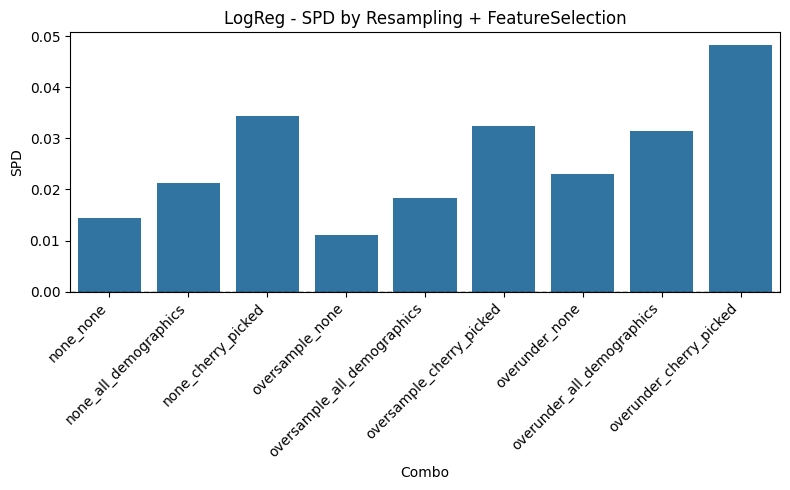

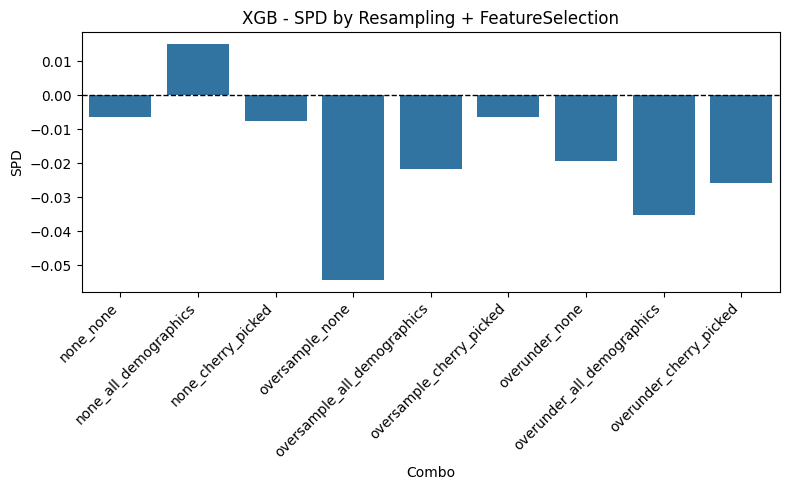

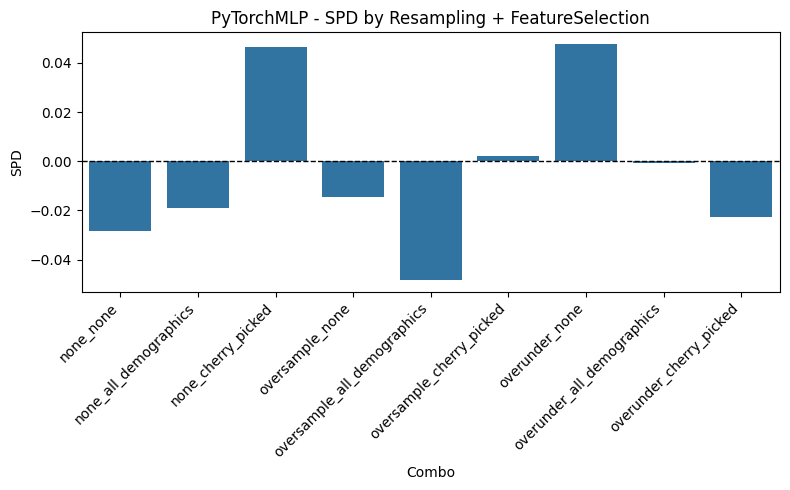

In [4]:

for mod in ["LogReg","XGB","PyTorchMLP"]:
    plot_spd_bars(df_combined, model_name=mod)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_auc_bars(df, model_name):
    dsub = df[df["model"] == model_name].copy()
    if dsub.empty:
        print(f"No rows for Model={model_name}. Skipping plot.")
        return

    dsub["Combo"] = dsub["Resampling"] + "_" + dsub["FeatureSelection"]

    plt.figure(figsize=(8,5))
    sns.barplot(data=dsub, x="Combo", y="auc")
    plt.ylim(0.55, 0.65)
    plt.title(f"{model_name} - AUC by Resampling + FeatureSelection")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


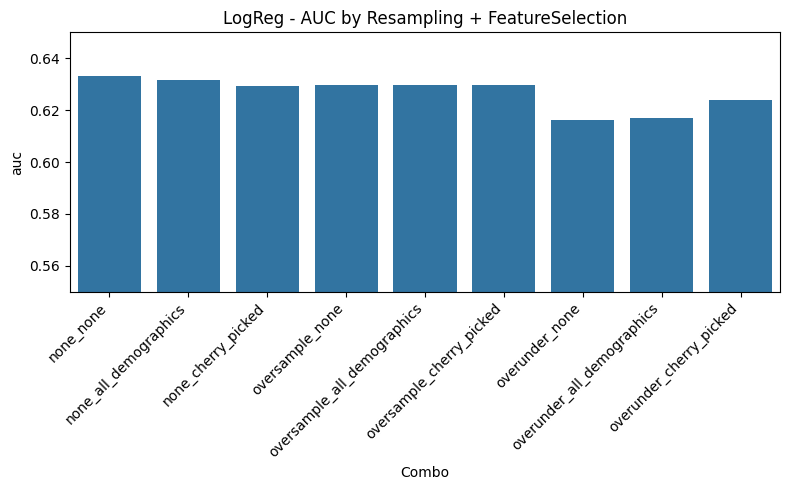

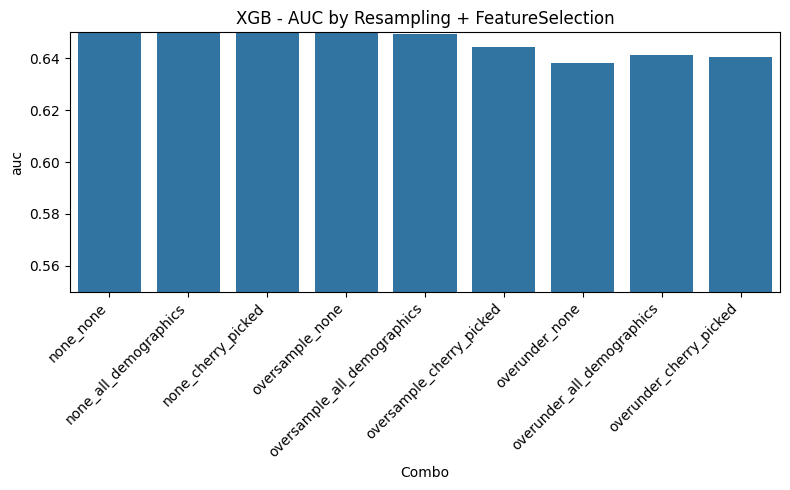

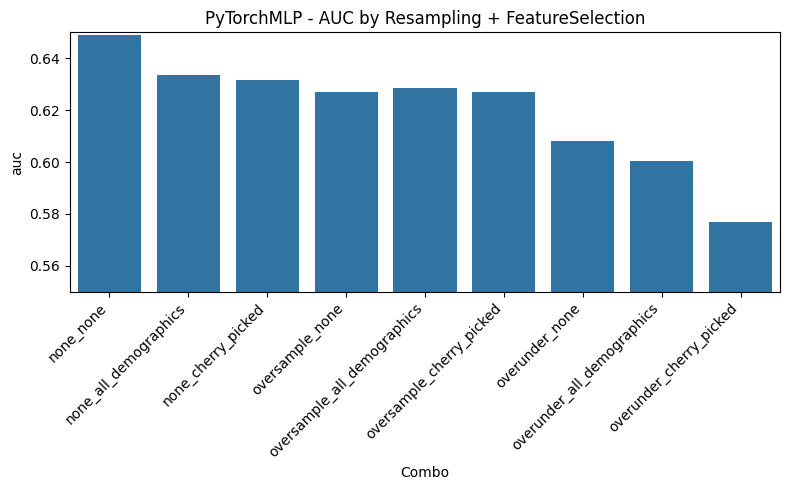

In [6]:

for mod in ["LogReg","XGB","PyTorchMLP"]:
    plot_auc_bars(df_combined, model_name=mod)

In [ ]:
import pandas as pd

def print_spd_correlations(df):
    # Filter to the relevant columns
    cols_of_interest = ['SPD','accuracy','recall','auc']
    # Check they exist in df
    for c in cols_of_interest:
        if c not in df.columns:
            print(f"[WARN] Column '{c}' not found in DataFrame.")
    subset = df[[c for c in cols_of_interest if c in df.columns]].dropna()

    # Compute correlation
    corr_matrix = subset.corr(method='pearson')

    # Print just SPD row if you want direct correlation with SPD
    if 'SPD' in corr_matrix.index:
        print("\n=== Correlation of SPD with Performance Metrics ===")
        for metric in ['accuracy','recall','auc']:
            if metric in corr_matrix.columns:
                print(f"SPD vs {metric}: {corr_matrix.loc['SPD', metric]:.4f}")
    else:
        print("[WARN] 'SPD' not found in columns, skipping correlation.")

    print("\n=== Full Correlation Matrix ===\n", corr_matrix)


print_spd_correlations(df_combined)



=== Correlation of SPD with Performance Metrics ===
SPD vs accuracy: 0.1715
SPD vs recall: -0.3305
SPD vs auc: -0.2928

=== Full Correlation Matrix ===
                SPD  accuracy    recall       auc
SPD       1.000000  0.171459 -0.330484 -0.292763
accuracy  0.171459  1.000000 -0.802904  0.134264
recall   -0.330484 -0.802904  1.000000  0.474258
auc      -0.292763  0.134264  0.474258  1.000000


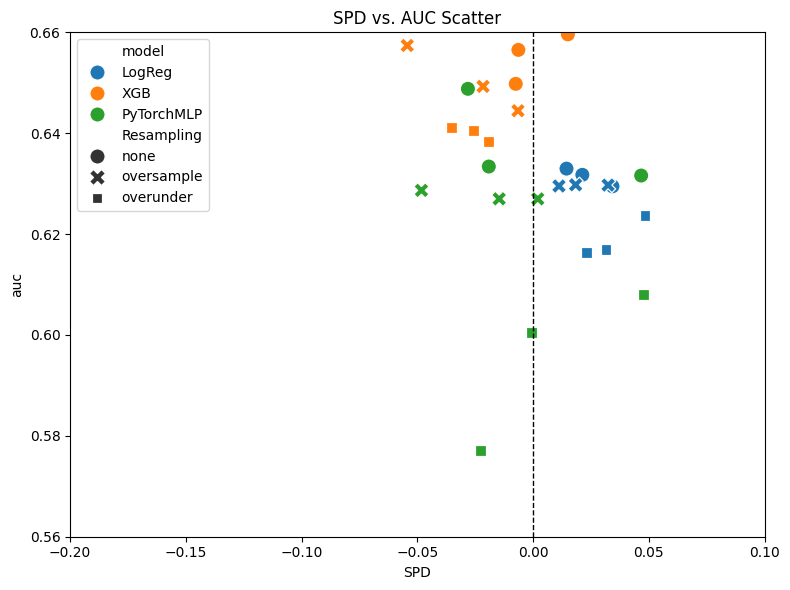

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_spd_vs_auc(df, xlim=None, ylim=None):
    if 'SPD' not in df.columns or 'auc' not in df.columns:
        print("[WARN] 'SPD' or 'auc' column missing in the DataFrame. Skipping plot.")
        return

    plt.figure(figsize=(8,6))
    sns.scatterplot(
        data=df,
        x='SPD',
        y='auc',
        hue='model',
        style='Resampling',
        s=120
    )
    # Reference lines for interpretability
    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)

    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)

    plt.title("SPD vs. AUC Scatter")
    plt.tight_layout()
    plt.show()


plot_spd_vs_auc(df_combined, xlim=(-0.2,0.1), ylim=(0.56,0.66))


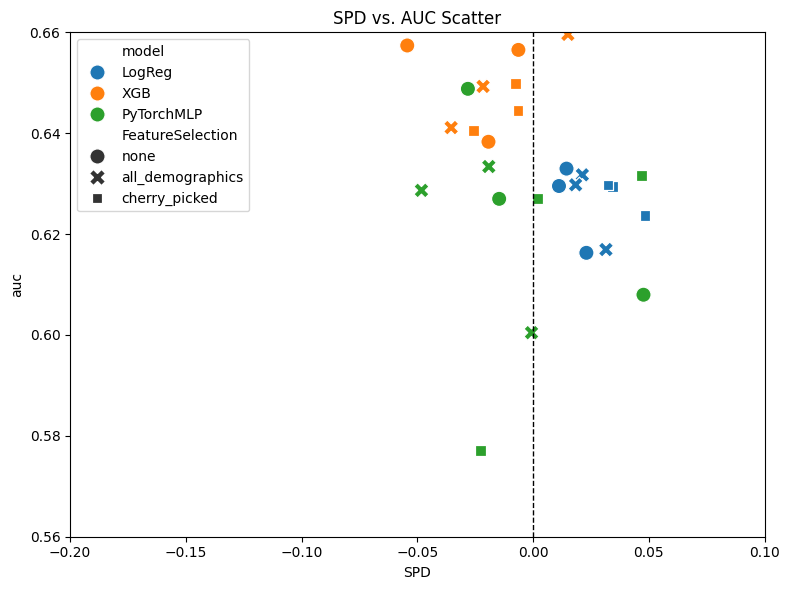

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_spd_vs_auc(df, xlim=None, ylim=None):
    if 'SPD' not in df.columns or 'auc' not in df.columns:
        print("[WARN] 'SPD' or 'auc' column missing in the DataFrame. Skipping plot.")
        return

    plt.figure(figsize=(8,6))
    sns.scatterplot(
        data=df,
        x='SPD',
        y='auc',
        hue='model',
        style='FeatureSelection',
        s=120
    )
    # Reference lines for interpretability
    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)

    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)

    plt.title("SPD vs. AUC Scatter")
    plt.tight_layout()
    plt.show()


plot_spd_vs_auc(df_combined, xlim=(-0.2,0.1), ylim=(0.56,0.66))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_spd_auc_by_resampling(df, model_name="LogReg"):
    # Filter to the chosen model
    dsub = df[df["model"] == model_name].copy()
    if dsub.empty:
        print(f"No rows found for model={model_name}.")
        return

    fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=False)

    # (A) Left Plot: SPD
    sns.barplot(
        data=dsub,
        x="Resampling",
        y="SPD",
        hue="FeatureSelection",
        ax=axes[0]
    )
    axes[0].axhline(0, color="black", linestyle="--", linewidth=1)
    axes[0].set_title(f"{model_name} - SPD by Resampling")
    axes[0].tick_params(axis='x', rotation=45)

    # (B) Right Plot: recall
    sns.barplot(
        data=dsub,
        x="Resampling",
        y="recall",
        hue="FeatureSelection",
        ax=axes[1]
    )
    axes[1].set_title(f"{model_name} - recall by Resampling")
    axes[1].tick_params(axis='x', rotation=45)

    fig.tight_layout()
    plt.show()


In [ ]:
def plot_spd_auc_by_features(df, model_name="LogReg"):
    dsub = df[df["model"] == model_name].copy()
    if dsub.empty:
        print(f"No rows found for model={model_name}.")
        return

    fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=False)

    # (A) Left Plot: SPD
    sns.barplot(
        data=dsub,
        x="FeatureSelection",
        y="SPD",
        hue="Resampling",
        ax=axes[0]
    )
    axes[0].axhline(0, color="black", linestyle="--", linewidth=1)
    axes[0].set_title(f"{model_name} - SPD by FeatureSelection")
    axes[0].tick_params(axis='x', rotation=45)

    # (B) Right Plot: recall
    sns.barplot(
        data=dsub,
        x="FeatureSelection",
        y="recall",
        hue="Resampling",
        ax=axes[1]
    )
    axes[1].set_title(f"{model_name} - recall by FeatureSelection")
    axes[1].tick_params(axis='x', rotation=45)

    fig.tight_layout()
    plt.show()


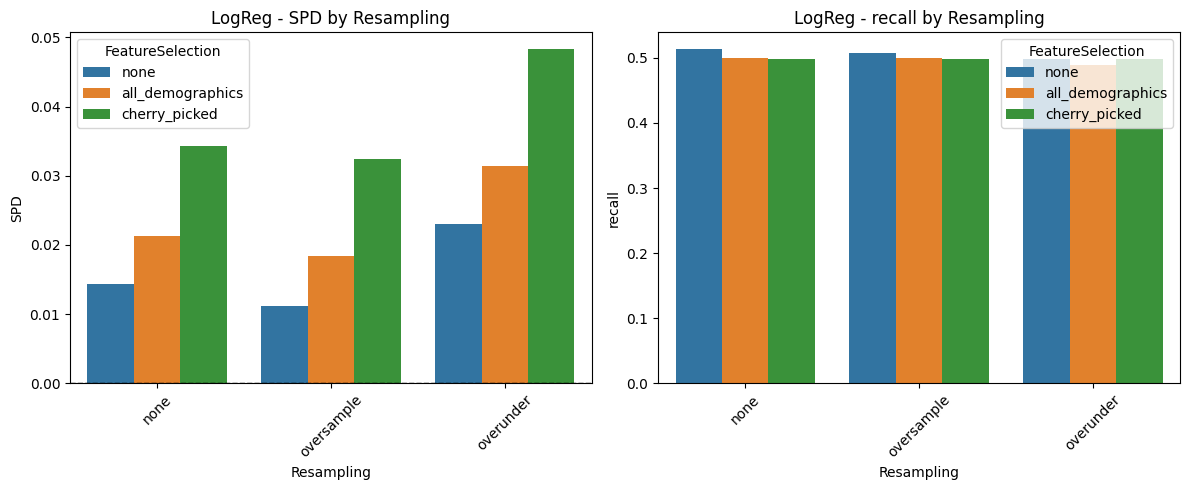

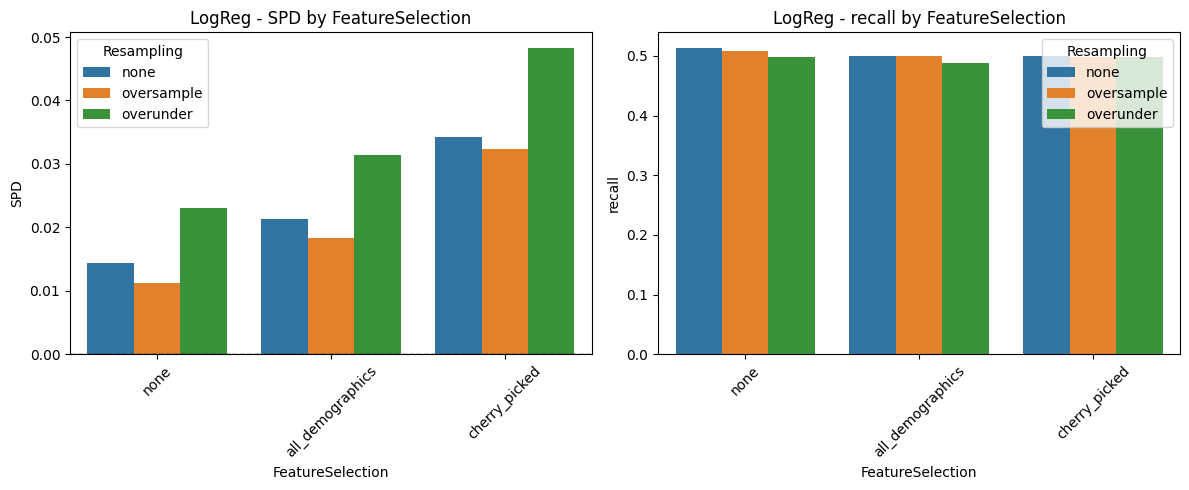

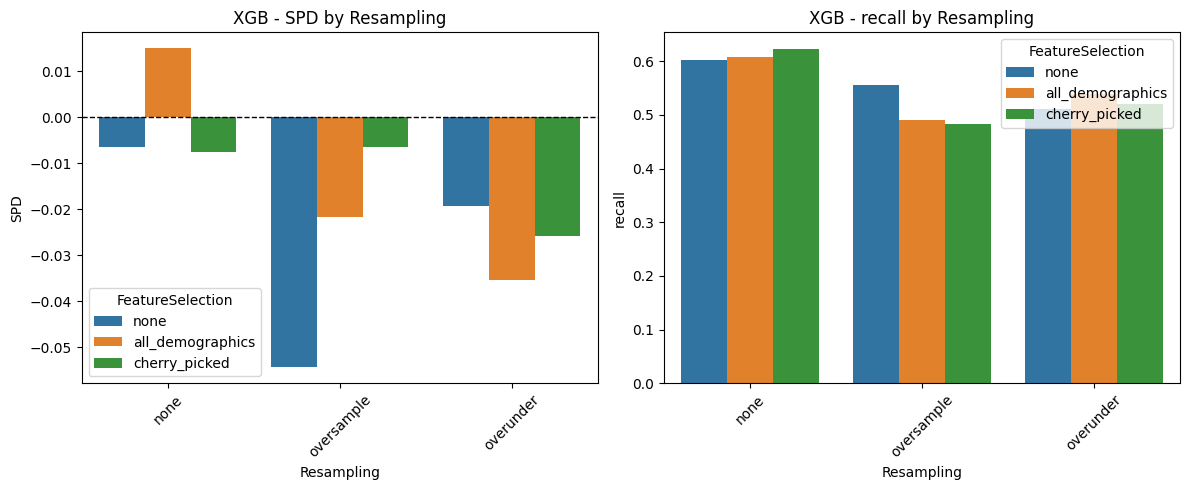

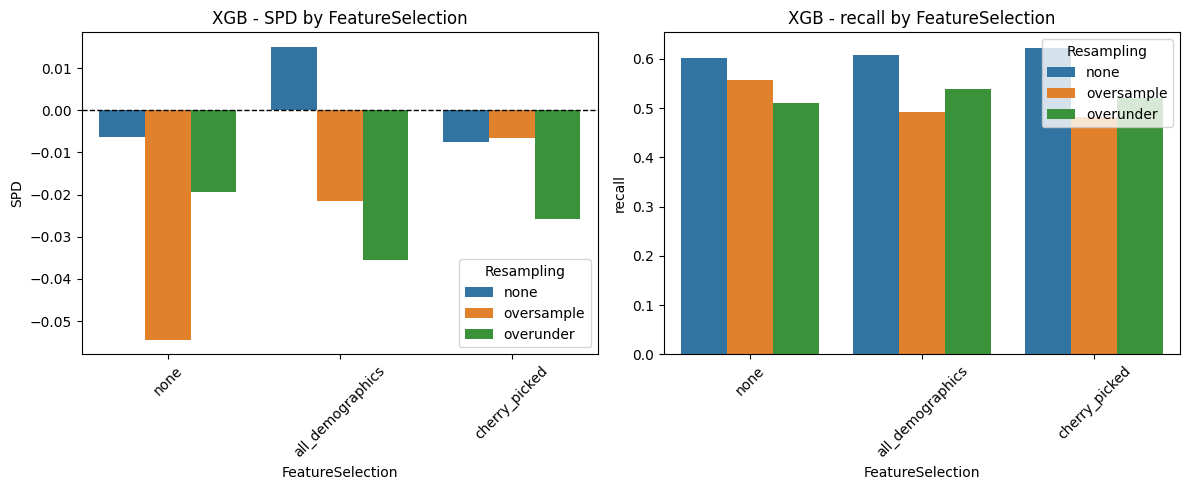

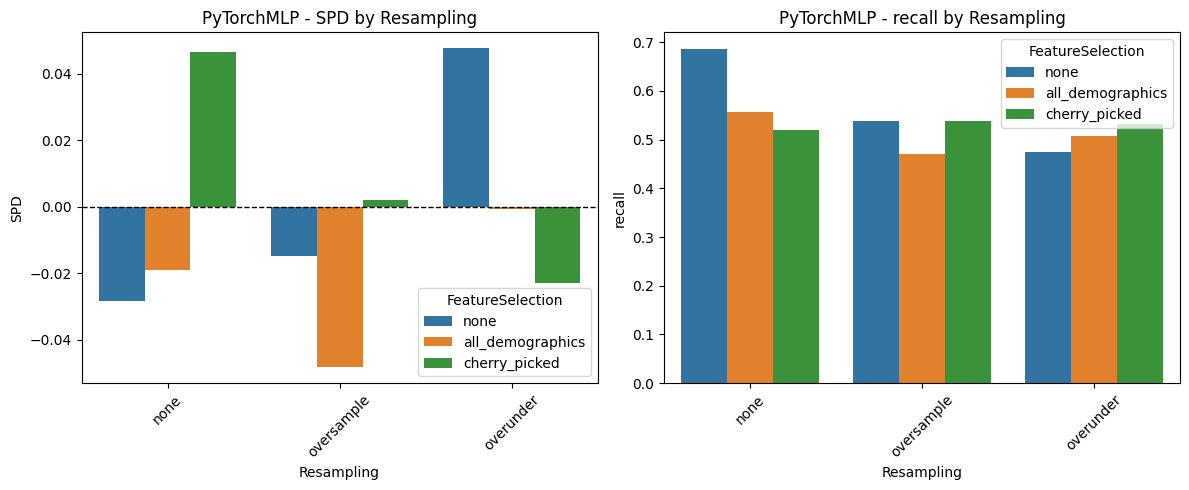

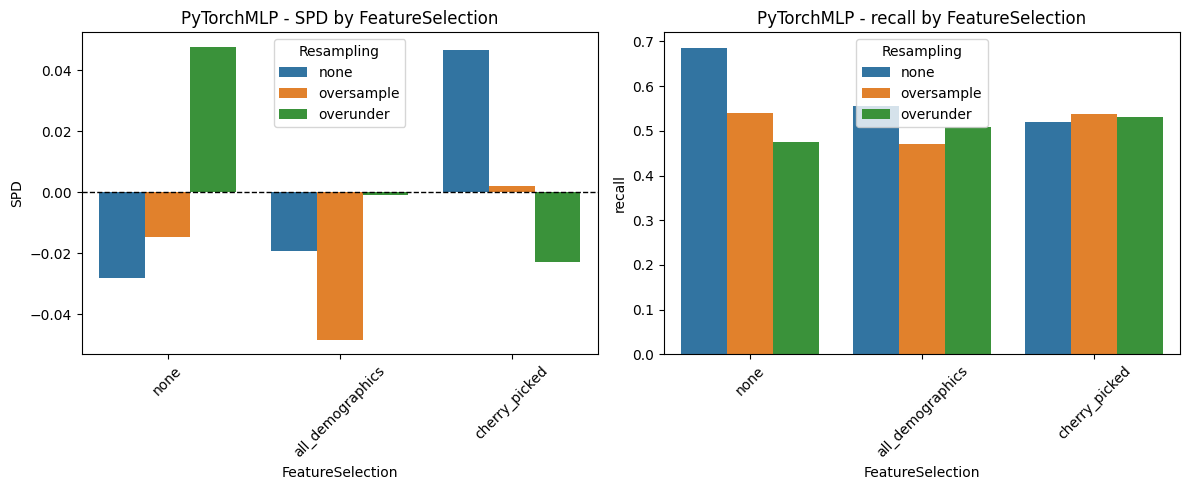

In [12]:
# Suppose df_combined has columns:
# [ "model","Resampling","FeatureSelection","SPD","auc", ... ]

models = ["LogReg","XGB","PyTorchMLP"]
for m in models:
    plot_spd_auc_by_resampling(df_combined, model_name=m)
    plot_spd_auc_by_features(df_combined, model_name=m)


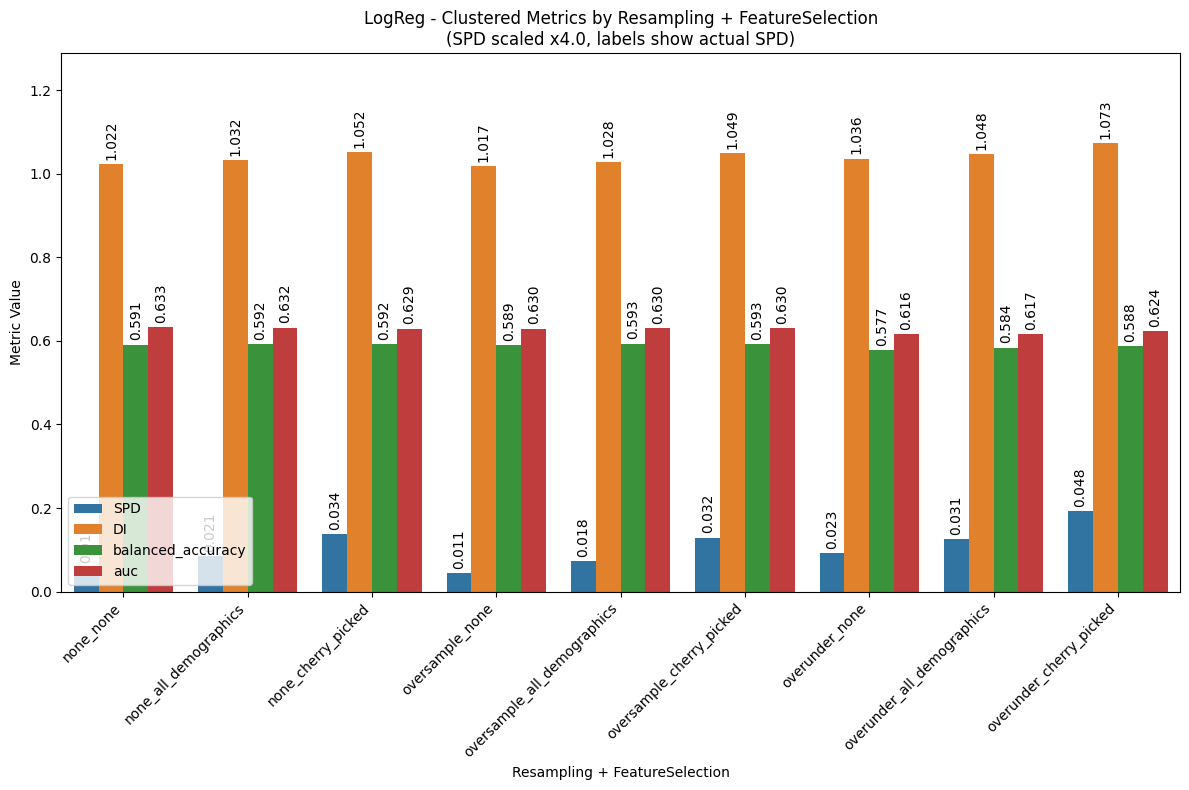

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_clustered_metrics(df, model_name="LogReg", spd_scale=4.0):
    dsub = df[df["model"] == model_name].copy()
    if dsub.empty:
        print(f"No rows for model={model_name}. Skipping plot.")
        return
    dsub["Combo"] = dsub["Resampling"] + "_" + dsub["FeatureSelection"]
    needed_cols = ["SPD", "DI", "balanced_accuracy", "auc"]
    missing_cols = [col for col in needed_cols if col not in dsub.columns]
    if missing_cols:
        print(f"Missing columns {missing_cols}. Cannot plot.")
        return
    agg_df = (
        dsub.groupby("Combo")[["SPD", "DI", "balanced_accuracy", "auc"]]
        .mean(numeric_only=True)
        .reset_index()
    )
    agg_df["SPD_original"] = agg_df["SPD"]
    agg_df["SPD"] = agg_df["SPD"].abs() * spd_scale
    combo_order = [
        "none_none",
        "none_all_demographics",
        "none_cherry_picked",
        "oversample_none",
        "oversample_all_demographics",
        "oversample_cherry_picked",
        "overunder_none",
        "overunder_all_demographics",
        "overunder_cherry_picked"
    ]
    agg_df["Combo"] = pd.Categorical(agg_df["Combo"], categories=combo_order, ordered=True)
    value_vars = ["SPD", "DI", "balanced_accuracy", "auc"]
    melted = agg_df.melt(
        id_vars="Combo",
        value_vars=value_vars,
        var_name="Metric",
        value_name="Value"
    )
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(
        data=melted,
        x="Combo",
        y="Value",
        hue="Metric",
        hue_order=value_vars,
        order=combo_order
    )
    plt.title(f"{model_name} - Clustered Metrics by Resampling + FeatureSelection\n(SPD scaled x{spd_scale}, labels show actual SPD)")
    plt.xlabel("Resampling + FeatureSelection")
    plt.ylabel("Metric Value")
    plt.xticks(rotation=45, ha="right")
    plt.legend(loc='lower left')
    spd_map = dict(zip(agg_df["Combo"], agg_df["SPD_original"]))
    for i, container in enumerate(ax.containers):
        if i == 0:
            spd_subset = melted[melted["Metric"] == "SPD"].copy()
            spd_subset["Combo"] = pd.Categorical(spd_subset["Combo"], categories=combo_order, ordered=True)
            spd_subset.sort_values("Combo", inplace=True)
            spd_values = spd_subset["Combo"].map(spd_map).values
            labels = [f"{v:.3f}" for v in spd_values]
        else:
            labels = [f"{p.get_height():.3f}" for p in container]
        ax.bar_label(container, labels=labels, padding=3, rotation=90)

    max_bar = melted["Value"].max()
    ax.set_ylim(0, max_bar * 1.2)
    plt.tight_layout()
    plt.show()


plot_clustered_metrics(df_combined, model_name="LogReg", spd_scale=4.0)


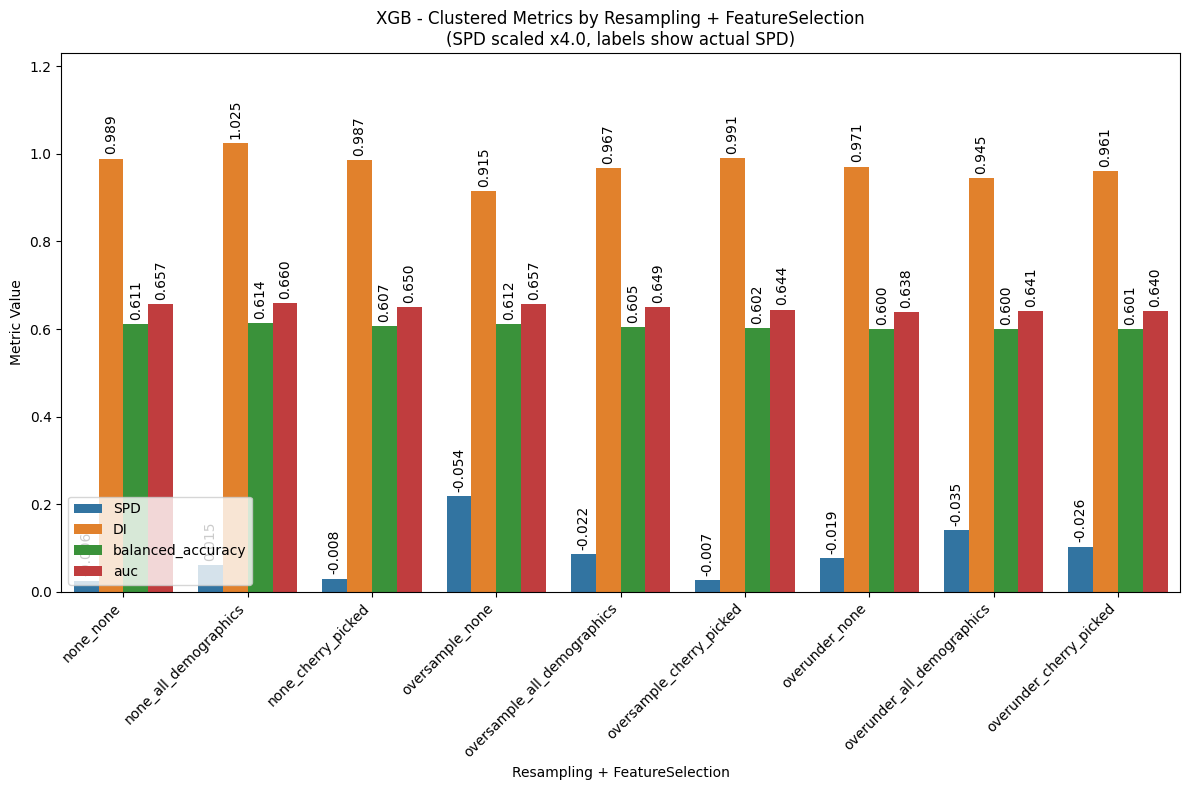

In [14]:
plot_clustered_metrics(df_combined, model_name="XGB", spd_scale=4.0)

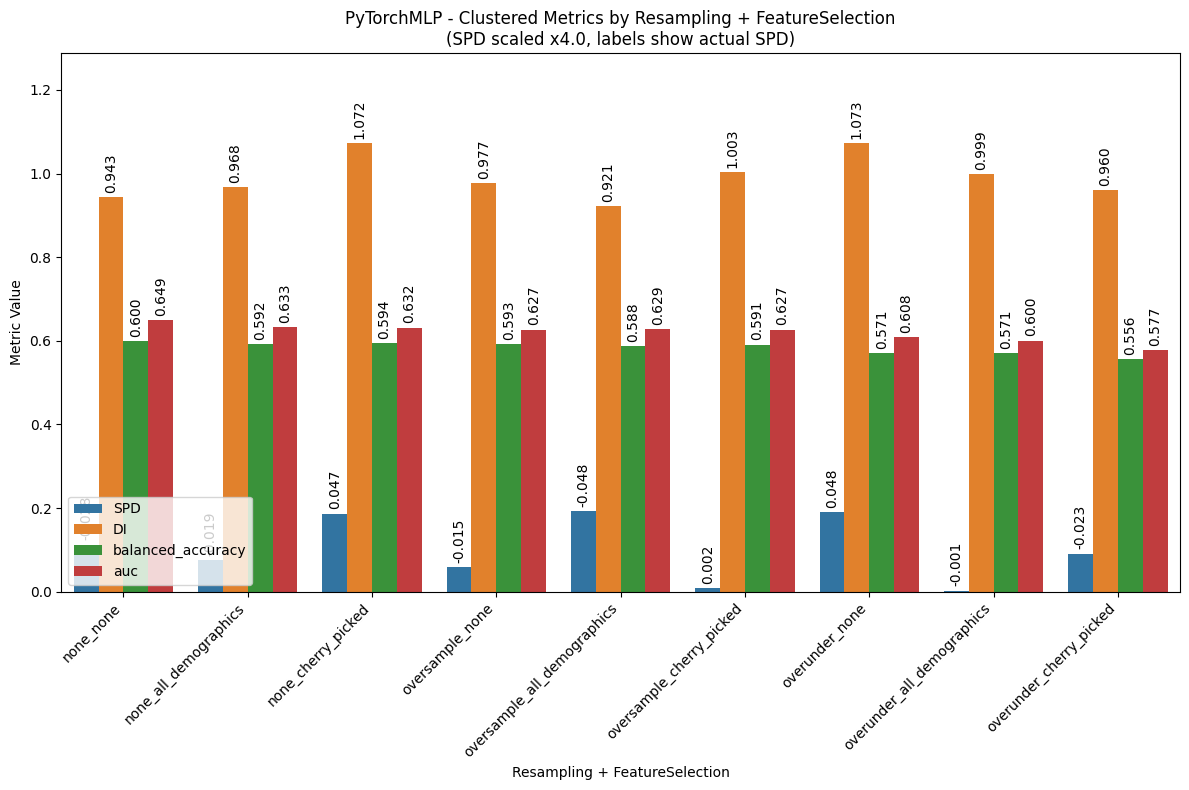

In [15]:
plot_clustered_metrics(df_combined, model_name="PyTorchMLP", spd_scale=4.0)